In [1]:
# import sys
# sys.path.append('../tools')

In [39]:
from fastai.vision.all import *
from fastai.text.all import *
from transformers import (BertTokenizer, AutoModel)
# from train_utils import *
import timm
from torch.jit import script_if_tracing
from tools.train_utils import *
from torchvision import transforms

In [3]:
base_path = 'data'
# base_path = '../data'

BERT_PATH = base_path + '/bert-indo-15g'

bert_model_file = base_path + '/saved_models/text_model/fine_tune_5epoch_bertindo15g-bs-64-mgrad-m06-08.pth'

bert_blend_embedding = base_path + '/saved_embeddings/text_embeddings/blend_indobert15g_embs.pth'

bert_embedding =  base_path + '/saved_embeddings/text_embeddings/fine_tune_5epoch_bertindo15g-bs-64-mgrad-m06-08_embed.pth'

image_model_file = base_path + '/saved_models/image_model/fine_tune_5epoch_nfnetl0-bs-64-pre-mgrad-adaptconcat-embed-1024-m08-10.pth'

image_embedding = base_path + '/saved_embeddings/image_embeddings/fine_tune_5epoch_nfnetl0-bs-64-pre-mgrad-adaptconcat-embed-1024-m08-10.pth'

image_blend_embedding = base_path + '/saved_embeddings/image_embeddings/blend_e5_eca_nfnetl0_embs.pth'


img_thresh =  0.5
bert_thresh = 0.8499999999999999
blend_img_thresh = 0.32
blend_bert_thresh = 0.48000000000000004

train_df = pd.read_csv(base_path +'/train.csv')



In [46]:
class InferenceClassifier(nn.Module):
    def __init__(self, emb, thresh=0.1,k=10):
        super().__init__()
        self.emb = nn.Parameter(emb,requires_grad=False)
        self.thresh = nn.Parameter(torch.tensor(thresh),requires_grad=False)
        self.k = nn.Parameter(torch.tensor((k)),requires_grad=False)

    def forward(self, x):
        dists = self.emb @ F.normalize(x).T
        top_vals, top_inds = dists.topk(self.k, dim=0, sorted=True)

        top_inds = top_inds[ top_vals > self.thresh] 
        top_vals = top_vals[ top_vals > self.thresh] 

        return (top_inds, top_vals)

def load_head(emb_file, thresh=0.6, k=10, norm=False):
    emb = torch.load(emb_file)
    if norm : emb = F.normalize(emb)
    head = InferenceClassifier(emb=emb,thresh=thresh,k=k)
    return head

In [85]:

# class BertArcFace(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.bert_model = AutoModel.from_pretrained(BERT_PATH)
#         self.classifier = None
#     def forward(self, x):
#         output = self.bert_model(x)
#         return self.classifier(output.last_hidden_state[:,0,:])


class BertArcFace(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert_model = AutoModel.from_pretrained(BERT_PATH,torchscript=True)
        self.classifier = None
    def forward(self, x,y):
        output, _ = self.bert_model(x,y)
        return self.classifier(output[:,0,:])


def load_bert_model(fname):
    model = BertArcFace()
    state = torch.load(fname)
    model.load_state_dict(state)

    return model.eval()


In [7]:
class ArcFaceNet(nn.Module):
    def __init__(self, arch, embedding_size=512, classifier=None):
        super().__init__()
        self.body = create_body(arch, cut=-2)
        nf = num_features_model(nn.Sequential(*self.body.children()))      
        self.after_conv=nn.Sequential(
                AdaptiveConcatPool2d(),
                Flatten(),
                nn.Linear(nf*2,embedding_size),
                nn.BatchNorm1d(embedding_size)
            )       

        self.classifier = classifier if classifier is not None else None

    def forward(self, x):
        x = self.body(x)
        return self.classifier(self.after_conv(x))
        
def load_image_model(fname,arch="eca_nfnet_l0"):
    state_dict = torch.load(fname)
    arch = timm.create_model(arch, pretrained = False)
    model = ArcFaceNet(arch=arch, embedding_size=1024)
    model.load_state_dict(state_dict)
    return model.eval()

In [8]:
#Taken from https://www.kaggle.com/c/shopee-product-matching/discussion/233605#1278984
def string_escape(s, encoding='utf-8'):
    return s.encode('latin1').decode('unicode-escape').encode('latin1').decode(encoding)

class InferenceTokenizer():
    def __init__(self, path):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(path)
               
    def encodes(self, text):

        text=string_escape(text)
        encodings = self.tokenizer(text, padding = 'max_length', max_length=100, truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask']
        return tuple(encodings[key] for key in keys)



In [86]:

bert_model = load_bert_model(bert_model_file)
blend_bert_model = load_bert_model(bert_model_file)

Some weights of the model checkpoint at data/bert-indo-15g were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at data/bert-indo-15g were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.

In [70]:
input_text = 'Victoria'
tokenizer = InferenceTokenizer(BERT_PATH)
input_text_processed =  tokenizer.encodes(input_text)
# tokenizer = 

In [77]:
bert_head = load_head(bert_embedding,norm=True,thresh=0.1,k=10)
bert_blend_head = load_head(bert_blend_embedding,thresh=0.1,k=10)


In [87]:

blend_bert_model.classifier = bert_blend_head
bert_model.classifier = bert_head

In [22]:
bert_res = bert_model(input_text_processed)
blend_bert_res = blend_bert_model(input_text_processed)


In [23]:
train_df[train_df["title"].str.contains(input_text)]

posting_id                                 image       image_phash  \
0  train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   

                       title  label_group  
0  Paper Bag Victoria Secret    249114794

In [24]:
train_df['title'].iloc[bert_res[0]]

33161                                                                       PAPER BAG VICTORIA SECRET
0                                                                           Paper Bag Victoria Secret
8469                                              b"victoria iria Goat's Milk Hand Body Lotion 250ml"
24302                                                                                 ELIZABETH DRESS
25386    READY! GRATIS ISI ULANG! Pengharum parfum mobil ruangan lemari tas victoria secret bombshell
20311                                                                                 Jilbab princess
23824                                                                                          Masker
33328                                                                                    Visor mx old
14605                                                                                        Beatrice
10315                                                     [LOKAL] DOMMO - D5039 DI

In [25]:
train_df['title'].iloc[blend_bert_res[0]]

0                                             Paper Bag Victoria Secret
33161                                         PAPER BAG VICTORIA SECRET
26895                                              FACE SHIELD FOR BABY
28655                                                     JILBAB MASKER
18730                                                  FACE SHIELD BABY
23824                                                            Masker
34058                                   face shield nagita series warna
8538     (TERMURAH) Face Shield Baby Bayi Newborn Pelindung Wajah Murah
10256                 KLINSKIN Beauty Soap Original BPOM BELI 2 DAPAT 3
7096                                               KLINSKIN BEAUTY SOAP
Name: title, dtype: object

In [26]:
image_model = load_image_model(image_model_file)
blend_image_model = load_image_model(image_model_file)

In [27]:
image_processing = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

In [28]:
input_image_file = 'data/test_images/example.jpg'
input_image = Image.open(input_image_file)

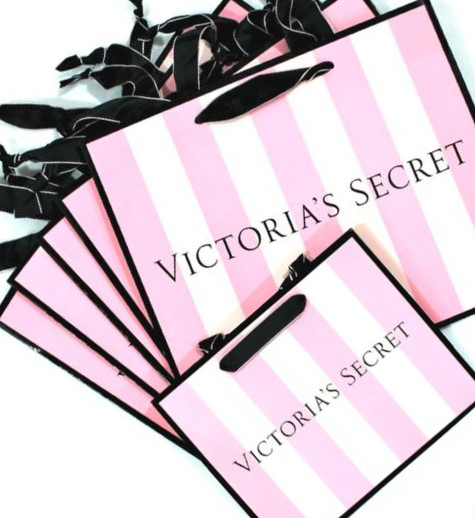

In [37]:
input_image.show()

In [29]:
input_image_processed = image_processing(input_image)
input_image_processed =  input_image_processed.unsqueeze(0)


In [48]:
image_head = load_head(image_embedding,norm=True,thresh=0.1)
image_blend_head = load_head(image_blend_embedding,thresh=0.1)

In [49]:

blend_image_model.classifier = image_blend_head
image_model.classifier = image_head

In [32]:
image_res = image_model(input_image_processed)
blend_image_res = blend_image_model(input_image_processed)

In [33]:
img_search = train_df[['title','image']].iloc[image_res[0].squeeze_()]

In [34]:
blend_img_search = train_df[['title', 'image']].iloc[blend_image_res[0].squeeze_()]

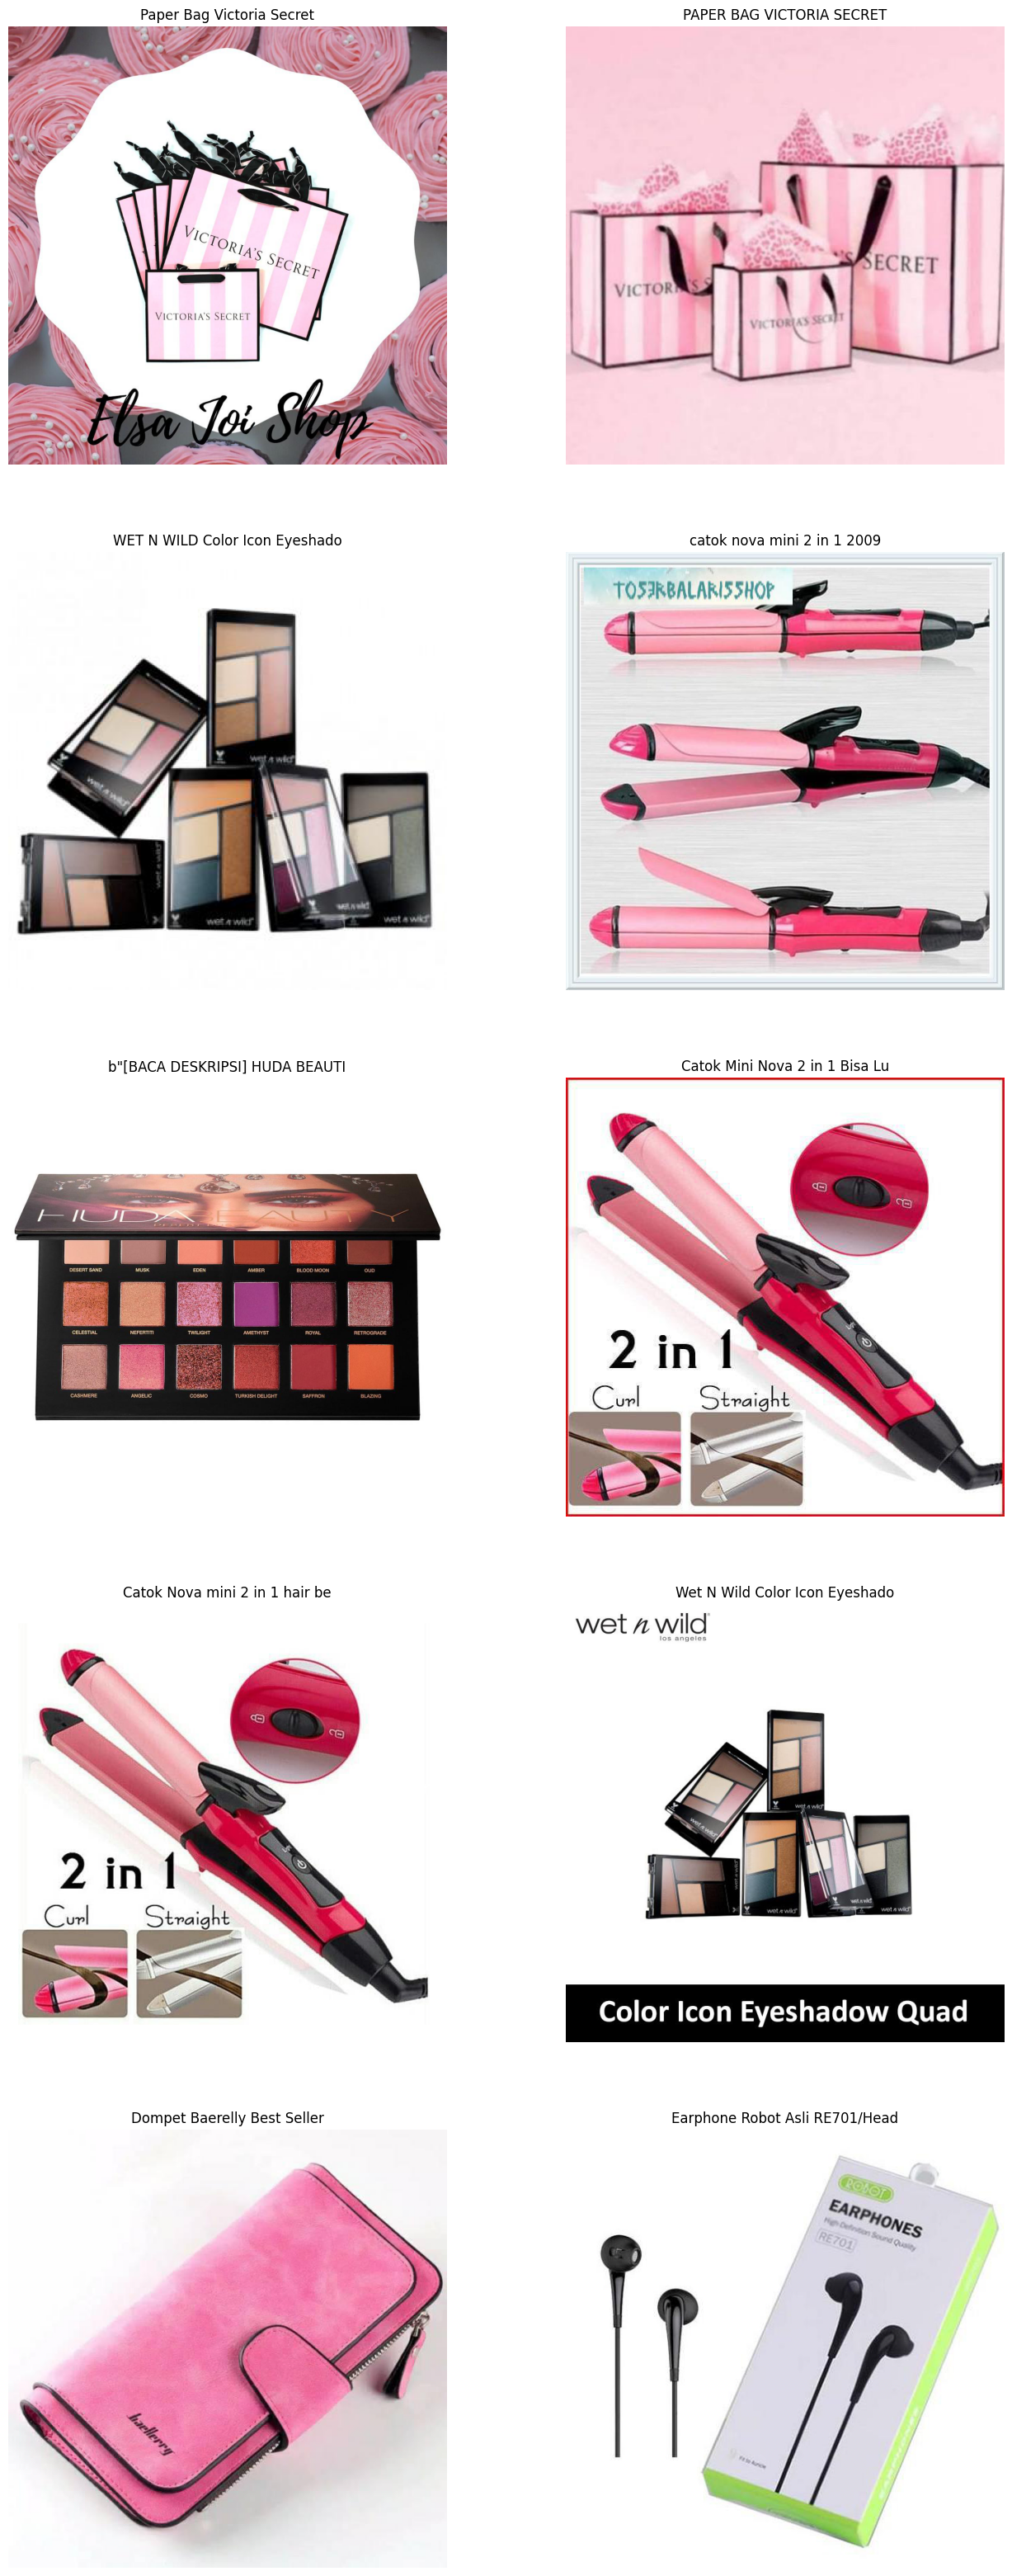

In [35]:
show_images([ Image.open('data/train_images/' + i)  for i in img_search['image'].to_list()], nrows=5, ncols=2, imsize=8,
                titles=[ i[:30]  for i in img_search['title'].to_list()])

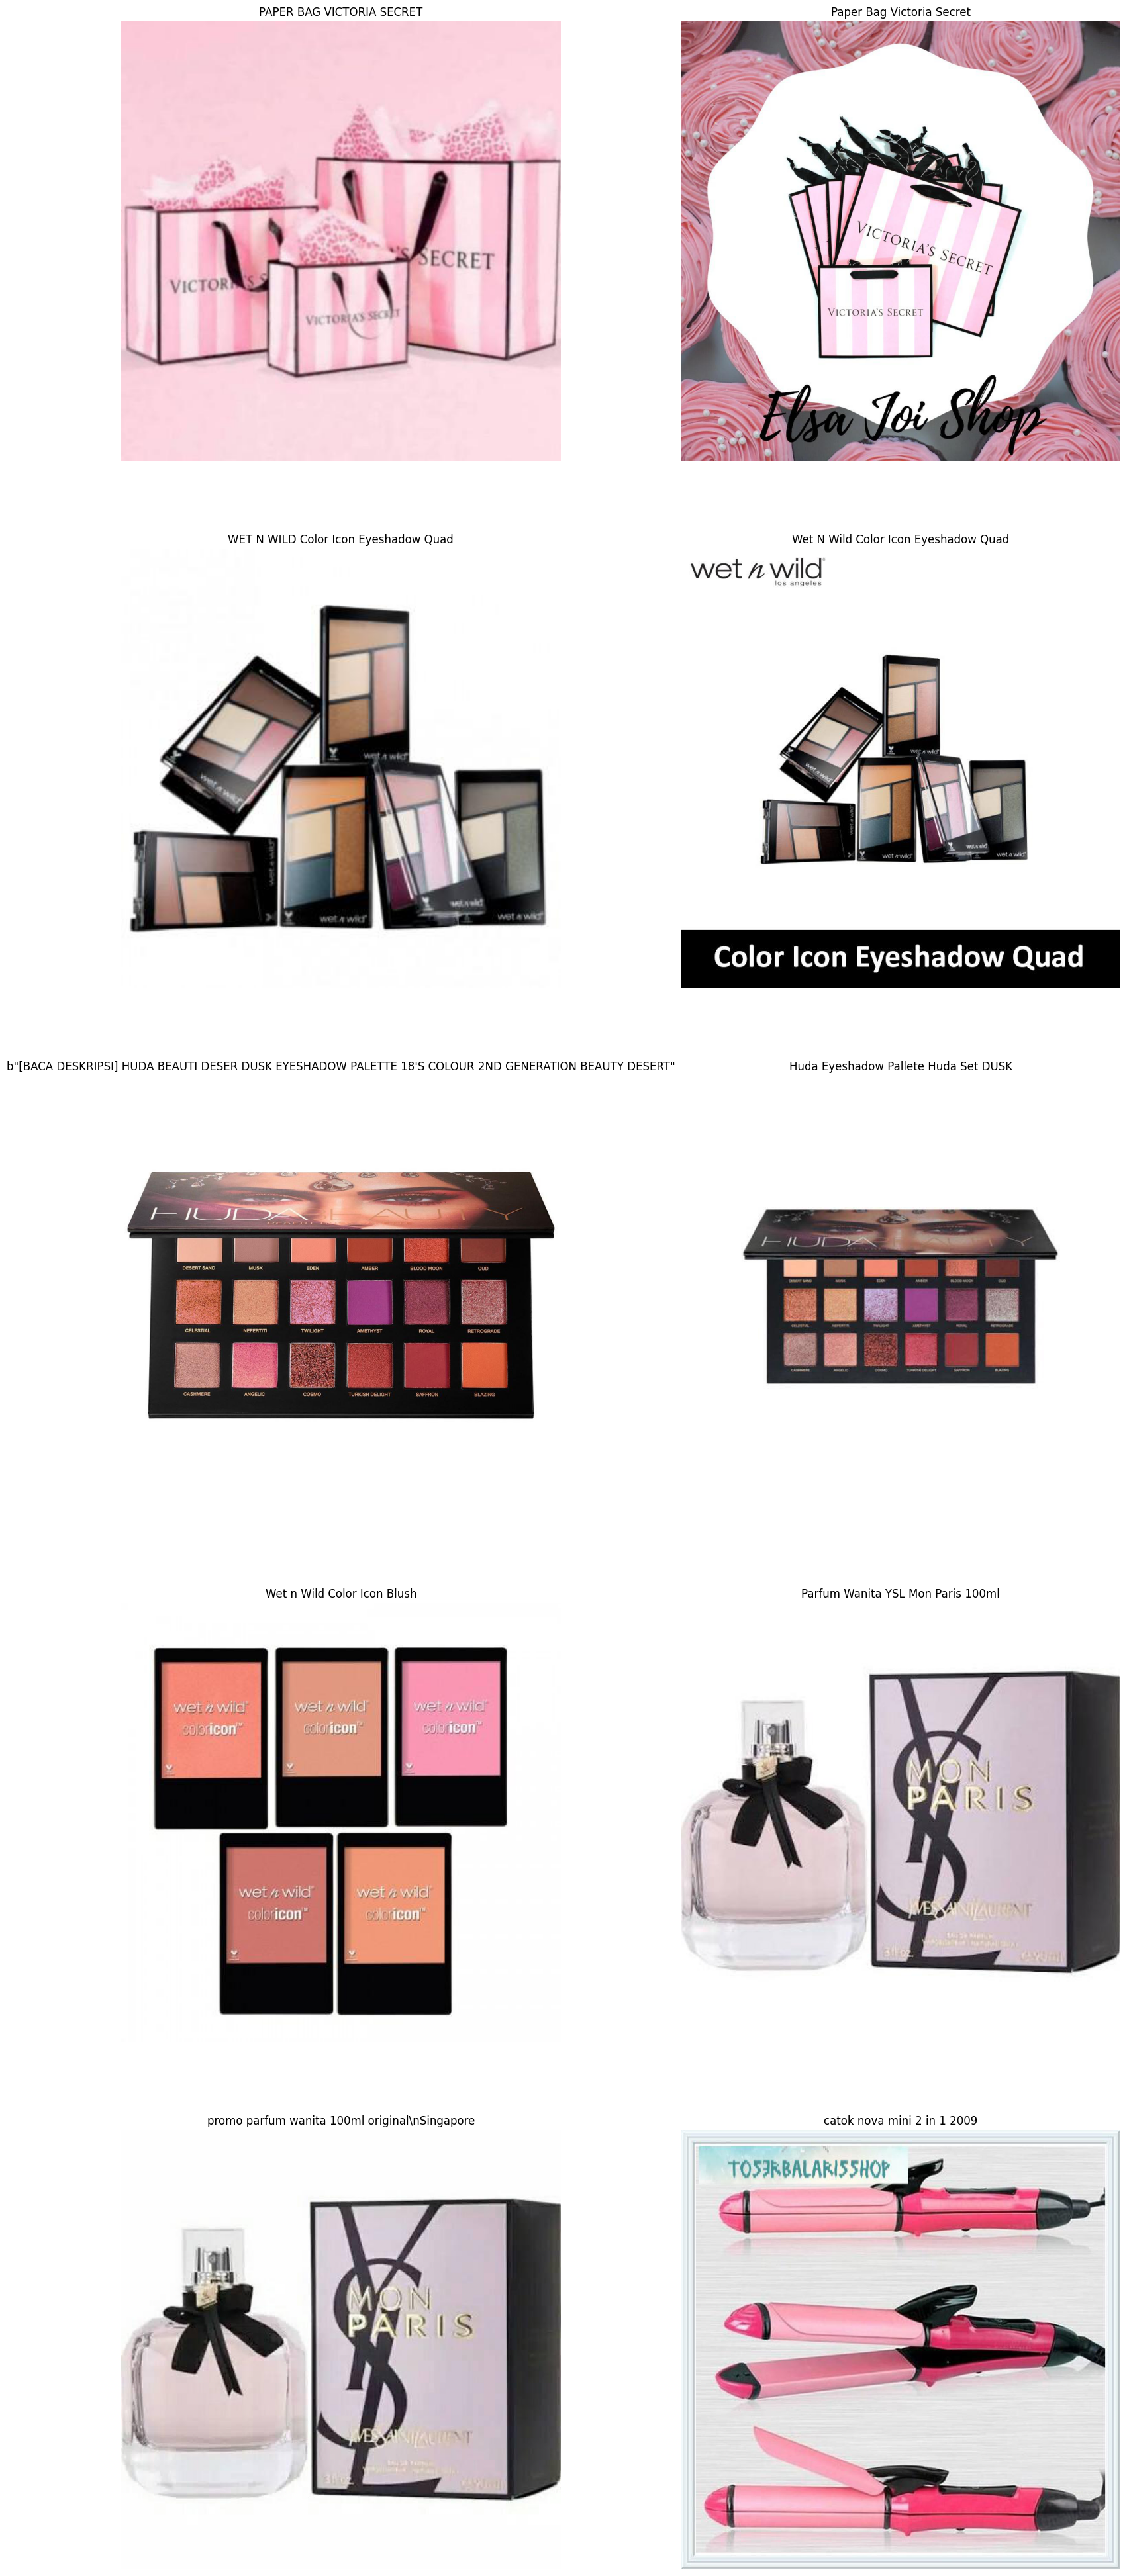

In [36]:
show_images([ Image.open('data/train_images/' + i)  for i in blend_img_search['image'].to_list()], nrows=5, ncols=2, imsize=10,
                titles=[ i for i in blend_img_search['title'].to_list()])

In [88]:
traced_img = torch.jit.trace(blend_image_model, input_image_processed)
traced_bert = torch.jit.trace(blend_bert_model, input_text_processed )


In [92]:
test = traced_bert(*input_text_processed)

In [94]:
torch.jit.save(traced_bert,'deploy/models/bert.pt')

In [95]:
torch.jit.save(traced_img,'deploy/models/nfnet.pt')